In [5]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects_new/MarsLanding_6dof_v7/Run/Run_4km_terminal


In [6]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


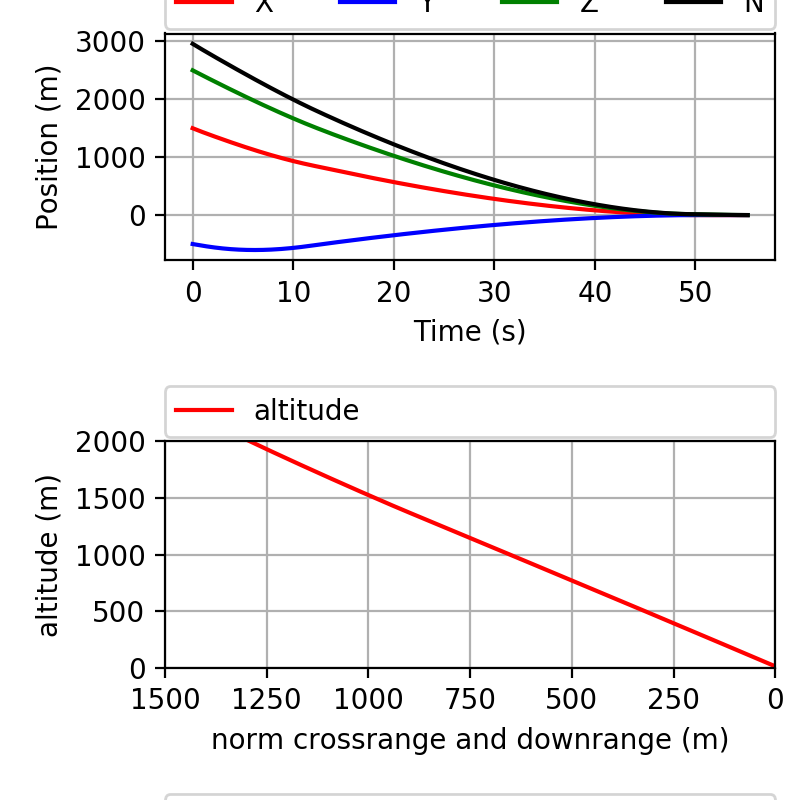

<IPython.core.display.Javascript object>


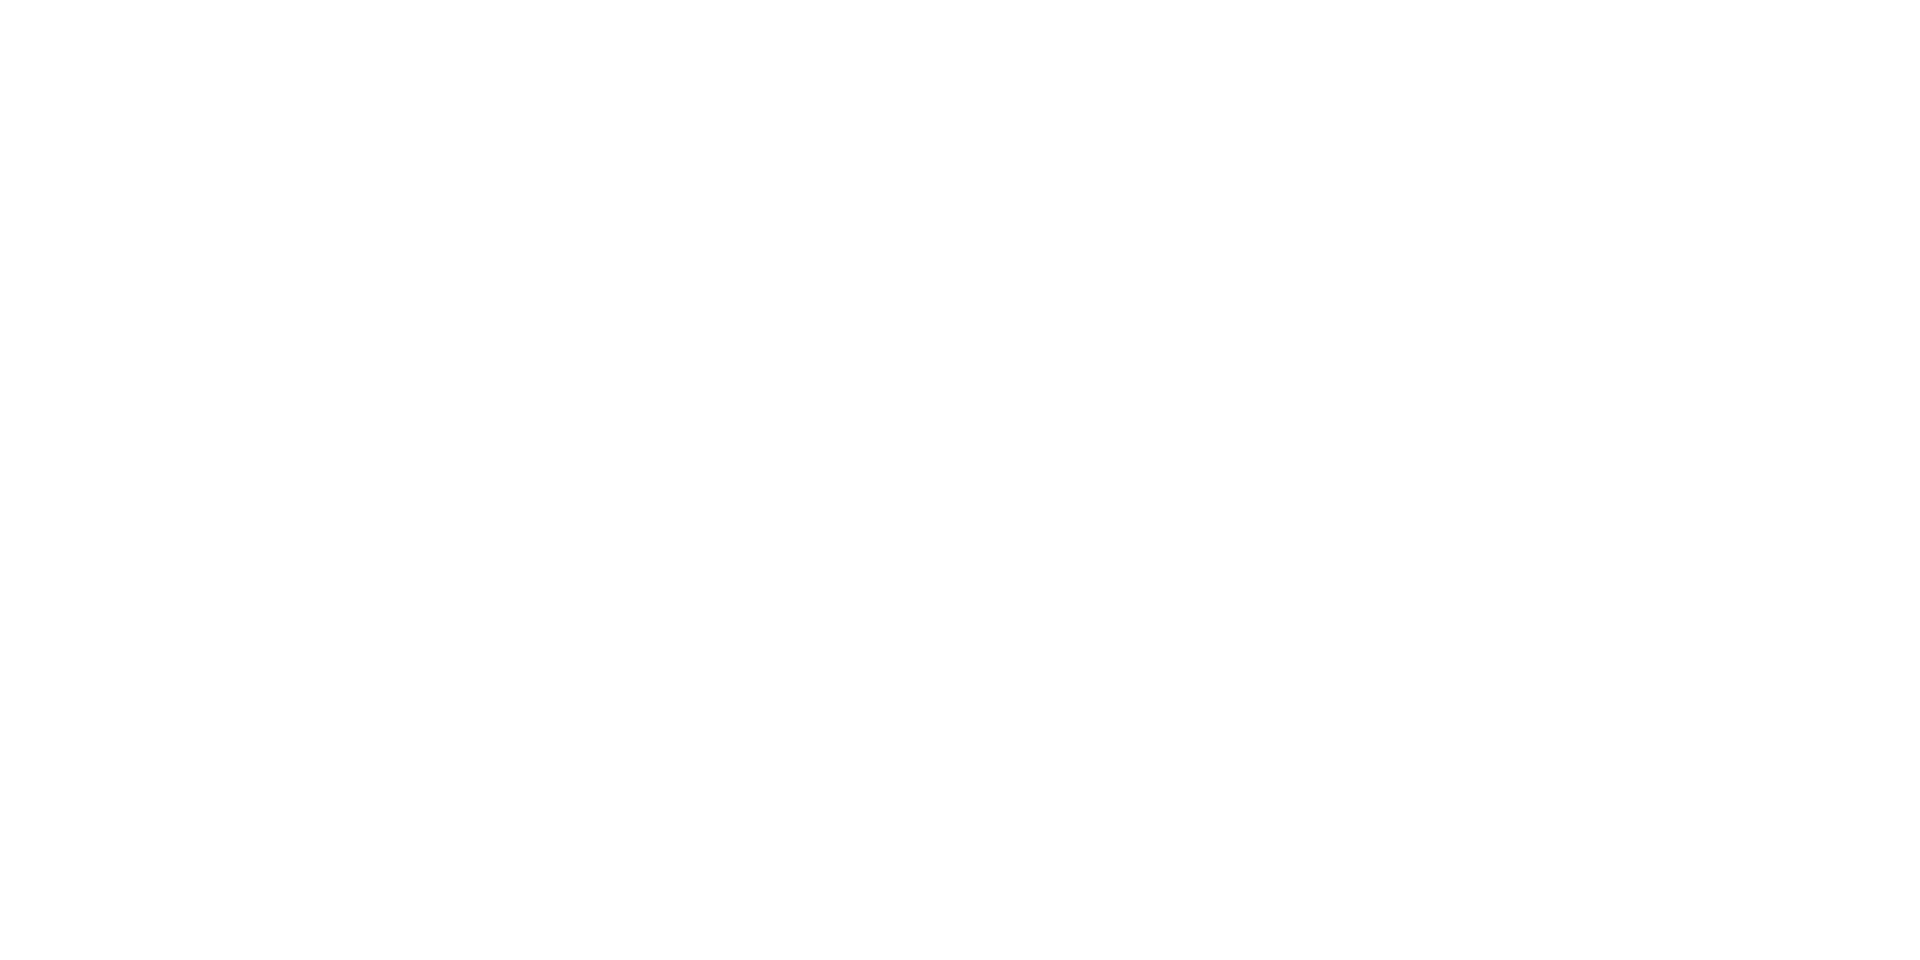

<IPython.core.display.Javascript object>


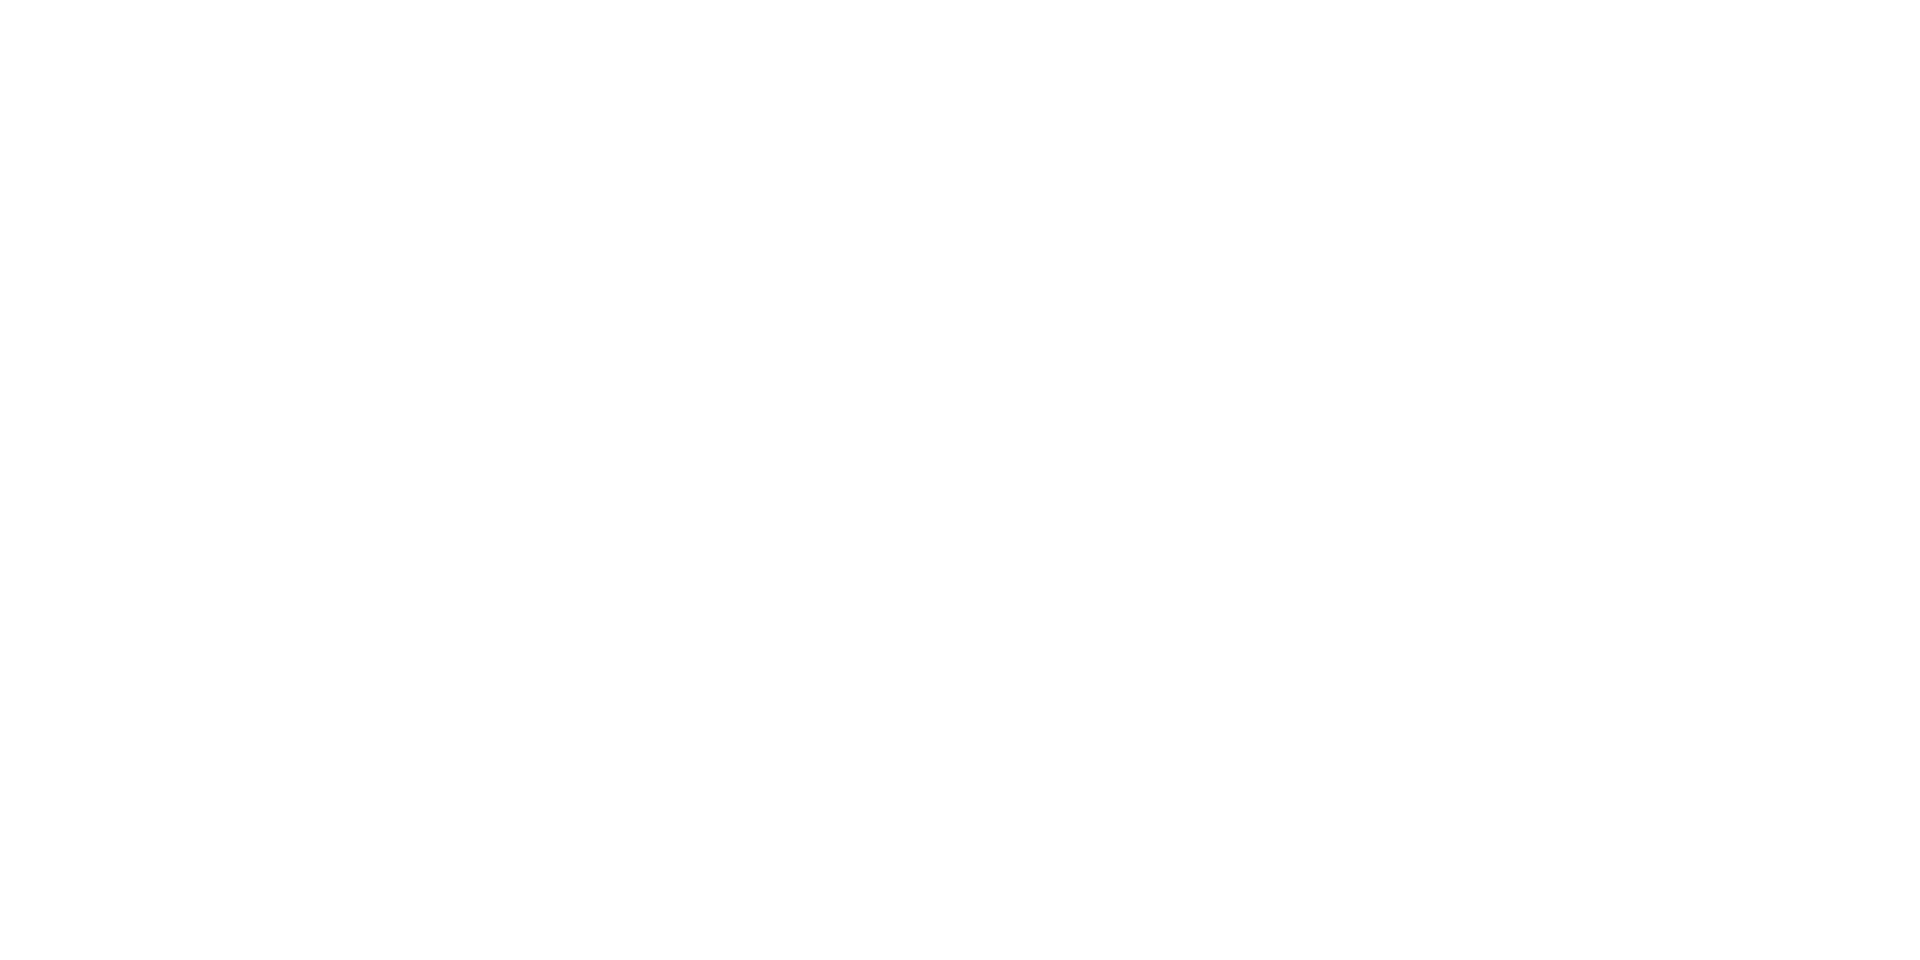

<IPython.core.display.Javascript object>


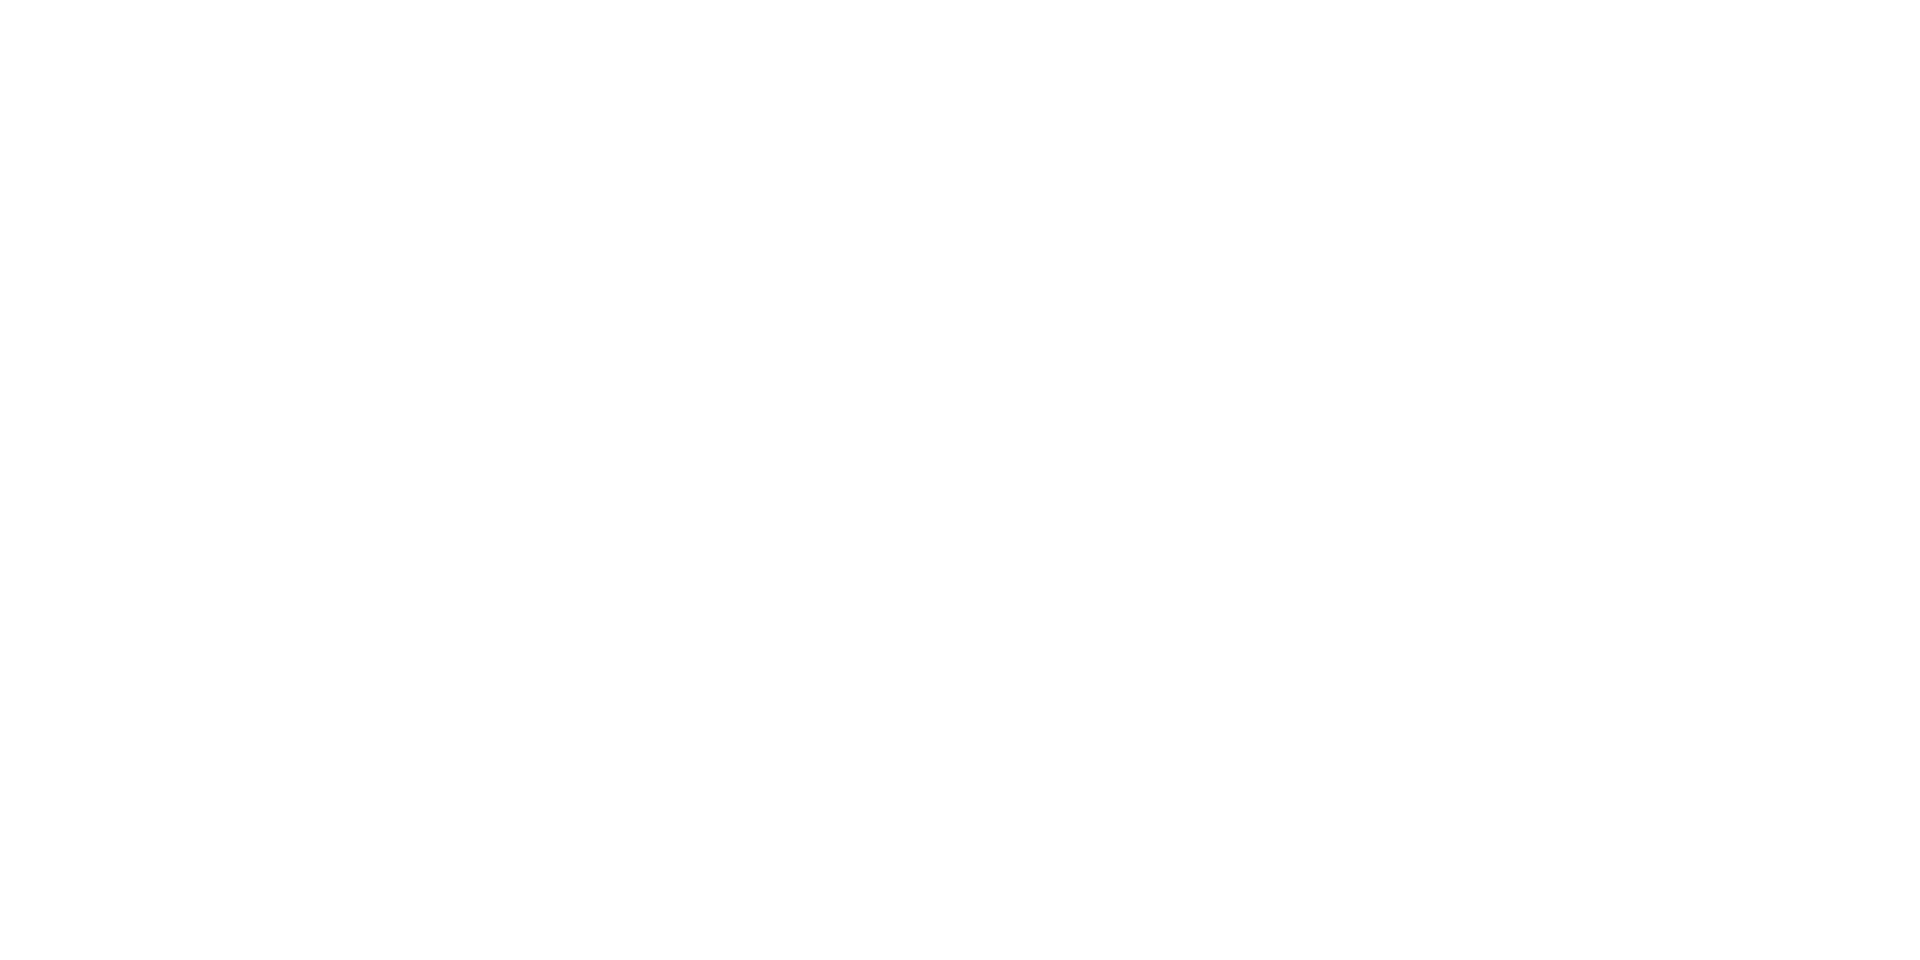

<IPython.core.display.Javascript object>


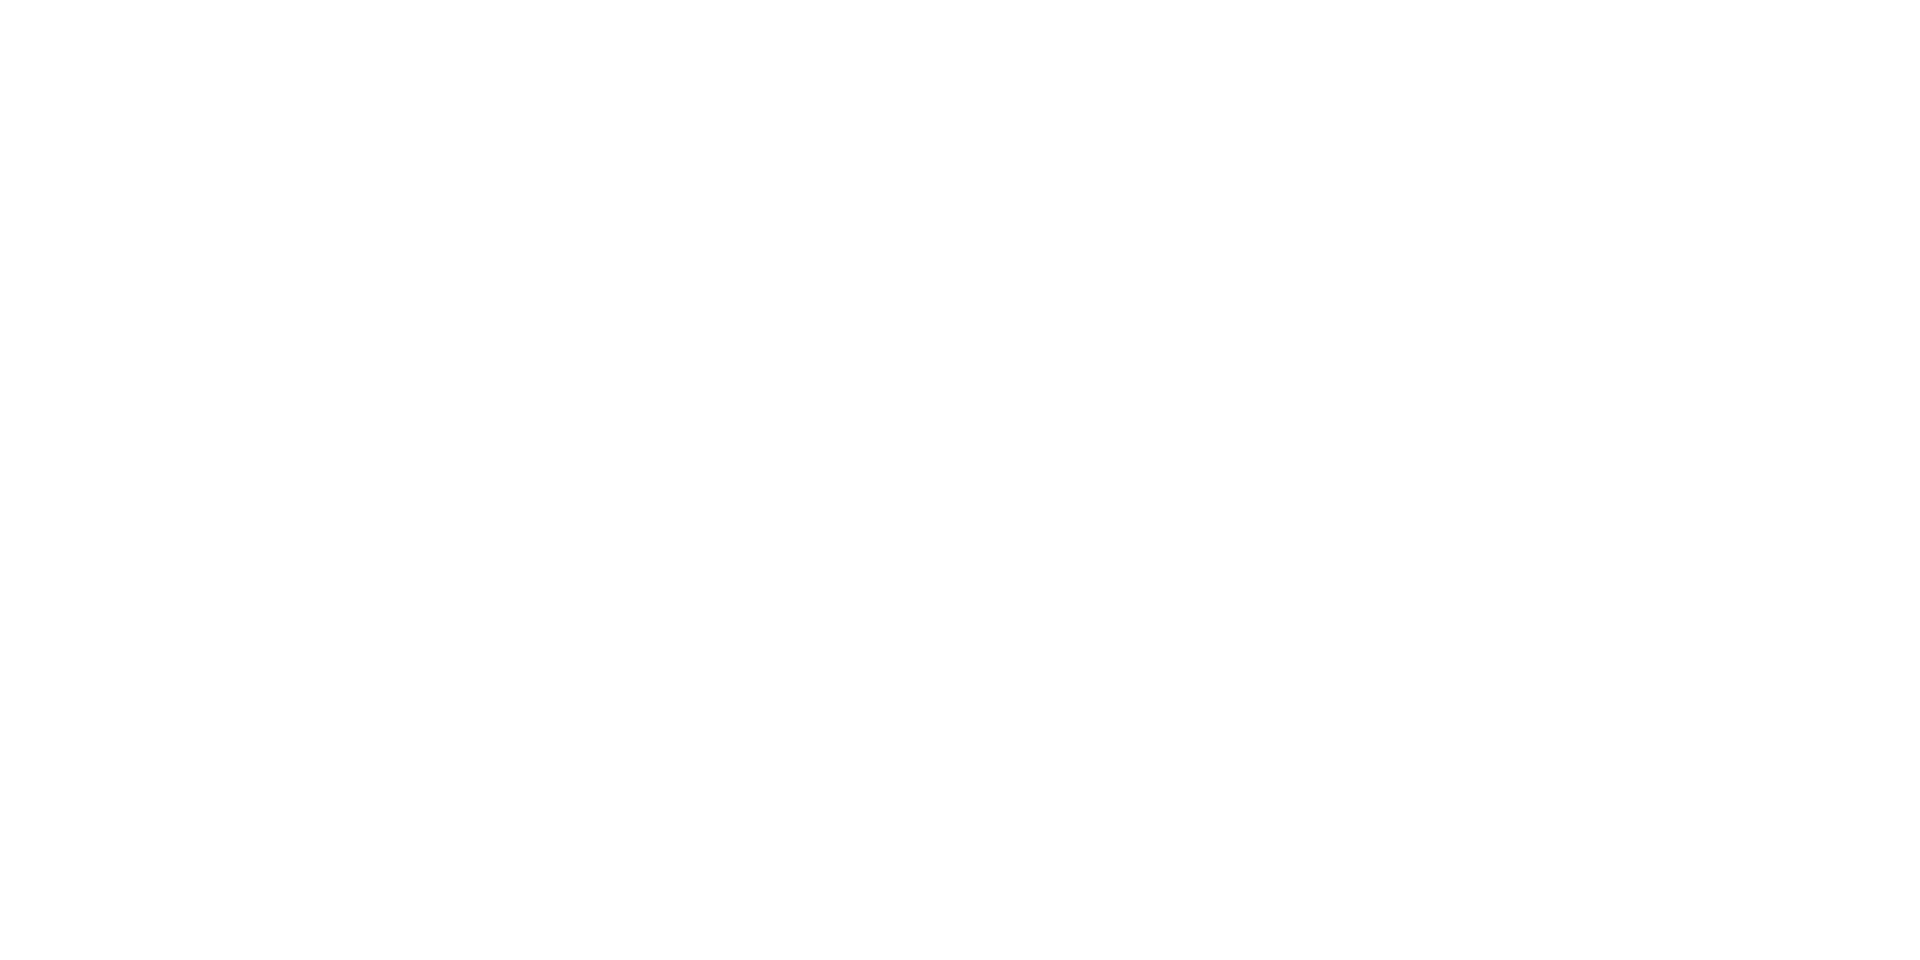

<IPython.core.display.Javascript object>


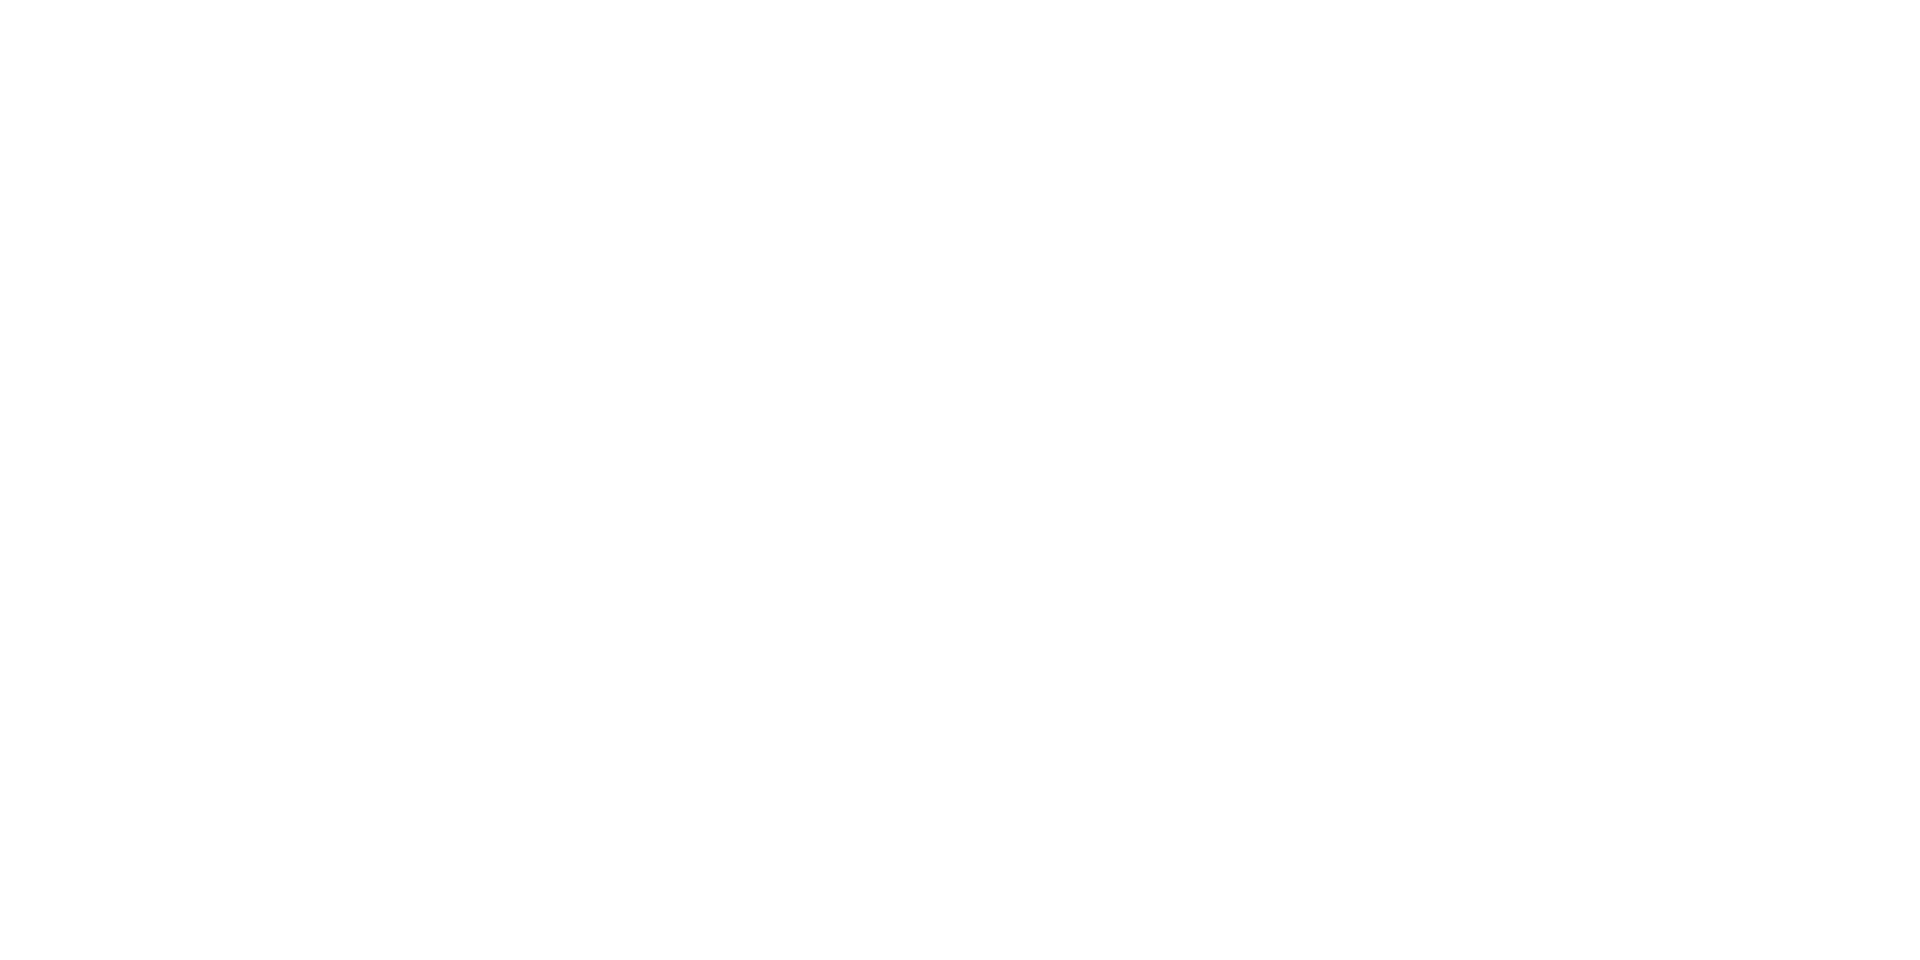

<IPython.core.display.Javascript object>


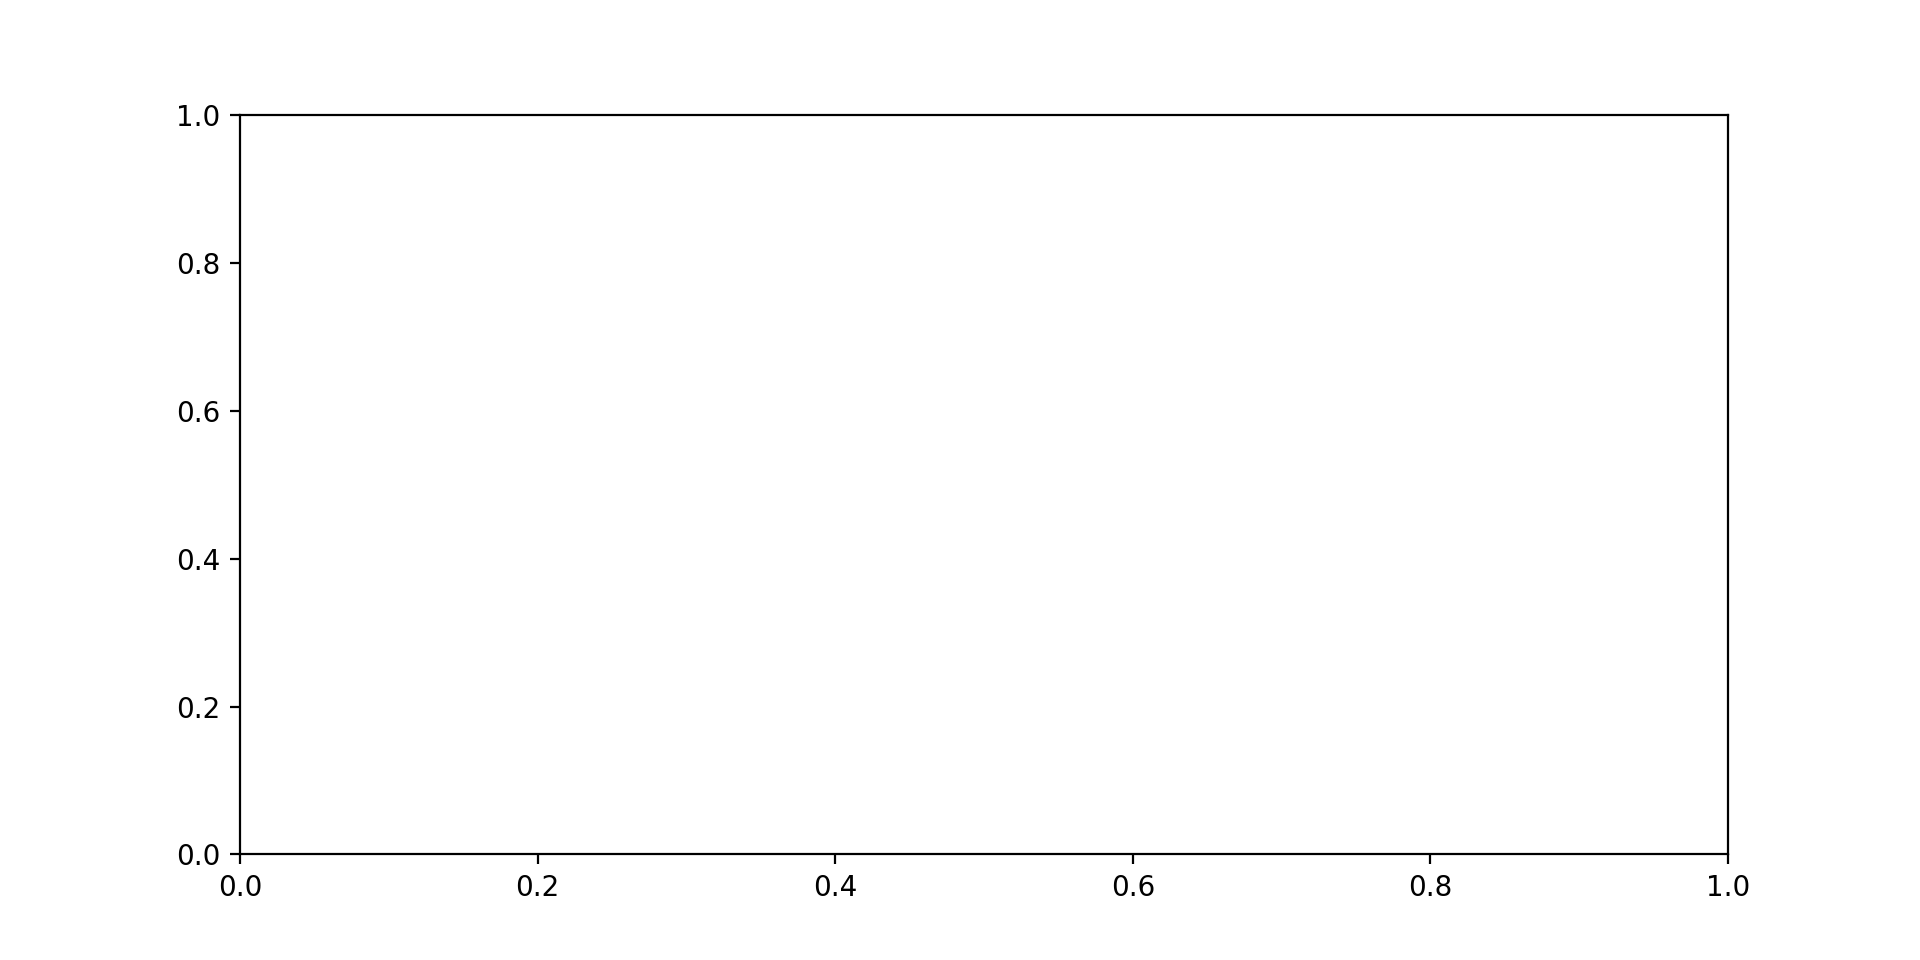

lander env att 2 fixed
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['means/kernel:0', 'h1/bias:0', 'h2/bias:0', 'means/bias:0', 'logvars:0', 'h3/bias:0', 'h1/kernel:0', 'h2/kernel:0', 'h3/kernel:0'])


In [8]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)




obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "small_reward-Copy1"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

In [7]:
policy.close_sess()
value_function.close_sess()

NameError: name 'value_function' is not defined

In [7]:
import utils
fname = "small_reward-Copy1"
#utils.save_run(policy,input_normalizer,fname)
utils.save_run(policy,input_normalizer,env.rl_stats.history,fname)

Saved Vars:  ['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0']


In [6]:
print(input_normalizer)

None


# Test Policy with Realistic Noise
## we slightly relax glideslope constraint

In [ ]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=-1.0
env.lander.apf_pot = env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2400,2500,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9734.16 |2449.25 |3200.00 |16000.00 |    19
glideslope | 3.813 | 7.603 | 0.941 |499.717 |    42
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.4     0.0 |    -1.1    -1.0    -0.0 |     1.6     1.3    -0.0
velocity |   0.050  -0.024  -0.947 |   0.025   0.069   0.047 |  -0.008  -0.151  -1.044 |   0.105   0.251  -0.845
fuel     |293.92 | 12.98 |268.76 |329.27
attitude_321 |  -0.026  -0.027  -0.014 |   0.180   0.010   0.023 |  -0.441  -0.052  -0.054 |   0.523  -0.000   0.048
w        |  -0.031  -0.007  -0.000 |   0.052   0.025   0.000 |  -0.152  -0.088  -0.000 |   0.086   0.067   0.000
glideslope |  18.559 |   7.378 |  10.049 |  61.377
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9687.80 |2392.55 |3200.00 |16000.00 |    19
glideslope | 3.656 | 6.848 | 0.865 |499.717 |    42
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9684.46 |2414.44 |3200.00 |16000.00 |   389
glideslope | 3.754 | 8.568 | 0.865 |2006.209 |  1018
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.0    -0.0 |     0.5     0.4     0.0 |    -1.5    -1.9    -0.0 |     2.6     1.6    -0.0
velocity |   0.052  -0.019  -0.943 |   0.026   0.071   0.049 |  -0.036  -0.168  -1.069 |   0.134   0.254  -0.738
fuel     |292.10 | 12.90 |266.87 |338.52
attitude_321 |  -0.041  -0.028  -0.012 |   0.181   0.012   0.023 |  -0.484  -0.068  -0.073 |   0.533   0.022   0.055
w        |  -0.030  -0.009  -0.000 |   0.054   0.027   0.000 |  -0.158  -0.148  -0.000 |   0.122   0.092   0.000
glideslope |  18.783 |   8.217 |   8.608 | 153.557
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9685.58 |2419.96 |3200.00 |16000.00 |   389
glideslope | 3.731 | 8.496 | 0.865 |2006.209 |  1018
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

In [ ]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=-1.0
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/16, np.pi/16, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/16, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/16, np.pi/16, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=30*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model fixed:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10432.67 |2776.90 |3200.00 |16000.00 |    20
glideslope | 3.791 | 7.689 | 1.014 |480.300 |    17
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   300.0  -300.6    -0.0 |     0.3     0.4     0.0 |   299.6  -302.0    -0.0 |   301.1  -299.5    -0.0
velocity |  -0.069  -0.064  -0.900 |   0.014   0.026   0.074 |  -0.101  -0.124  -1.042 |  -0.031  -0.014  -0.657
fuel     |272.52 | 11.21 |253.00 |316.11
attitude |  -0.099  -0.001   0.001 |   0.045   0.005   0.011 |  -0.220  -0.013  -0.041 |   0.120   0.016   0.022
w        |   0.009   0.010   0.000 |   0.025   0.014   0.000 |  -0.054  -0.022  -0.000 |   0.082   0.060   0.000
gl

<IPython.core.display.Javascript object>


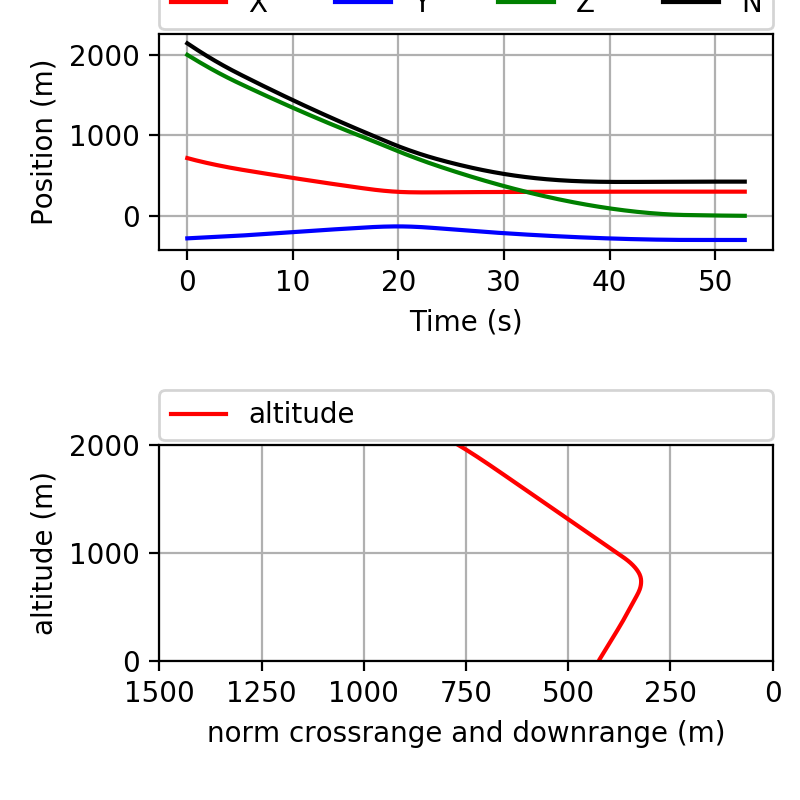

In [63]:
from lander_model2 import Lander_model
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10., divert=(300,-300,1000))
lander_model.get_state_agent = lander_model.get_state_agent9
lander_model.apf_pot = lander_model.apf_pot4
env.lander=lander_model

policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           downrange = (500,1500 , -70, -10), 
                           crossrange = (-500,500 , -30,30),  
                           altitude = (2000,2000,-90,-70),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1000,print_every=100)
envu.render_traj(lander_model.trajectory_list[0])

In [64]:
envu.render_traj(lander_model.trajectory_list[10])


Cumulative Stats (mean,std,max,argmax)
thrust   |10314.43 |2846.96 |3200.00 |16000.00 |     0
glideslope | 3.058 |12.143 | 1.187 |194.987 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.3    -0.4    -0.0 |     0.0     0.0     0.0 |     0.3    -0.4    -0.0 |     0.3    -0.4    -0.0
velocity |   0.081  -0.051  -0.992 |   0.000   0.000   0.000 |   0.081  -0.051  -0.992 |   0.081  -0.051  -0.992
fuel     |279.35 |  0.00 |279.35 |279.35
attitude_321 |   0.170  -0.022   0.054 |   0.000   0.000   0.000 |   0.170  -0.022   0.054 |   0.170  -0.022   0.054
w        |  -0.113  -0.049   0.000 |   0.000   0.000   0.000 |  -0.113  -0.049   0.000 |  -0.113  -0.049   0.000
glideslope |  17.698 |   0.000 |  17.698 |  17.698

Initial Stats (mean,std,min,max)
position |  1500.0  -500.0  2500.0 |     0.0     0.0     0.0 |  1500.0  -500.0  2500.0 |  1500.0  -500.0  2500.0
velocity | -70.000 -30.000 -90.000 |   0.000   0.000   0.000 | -70.000 -3

<IPython.core.display.Javascript object>


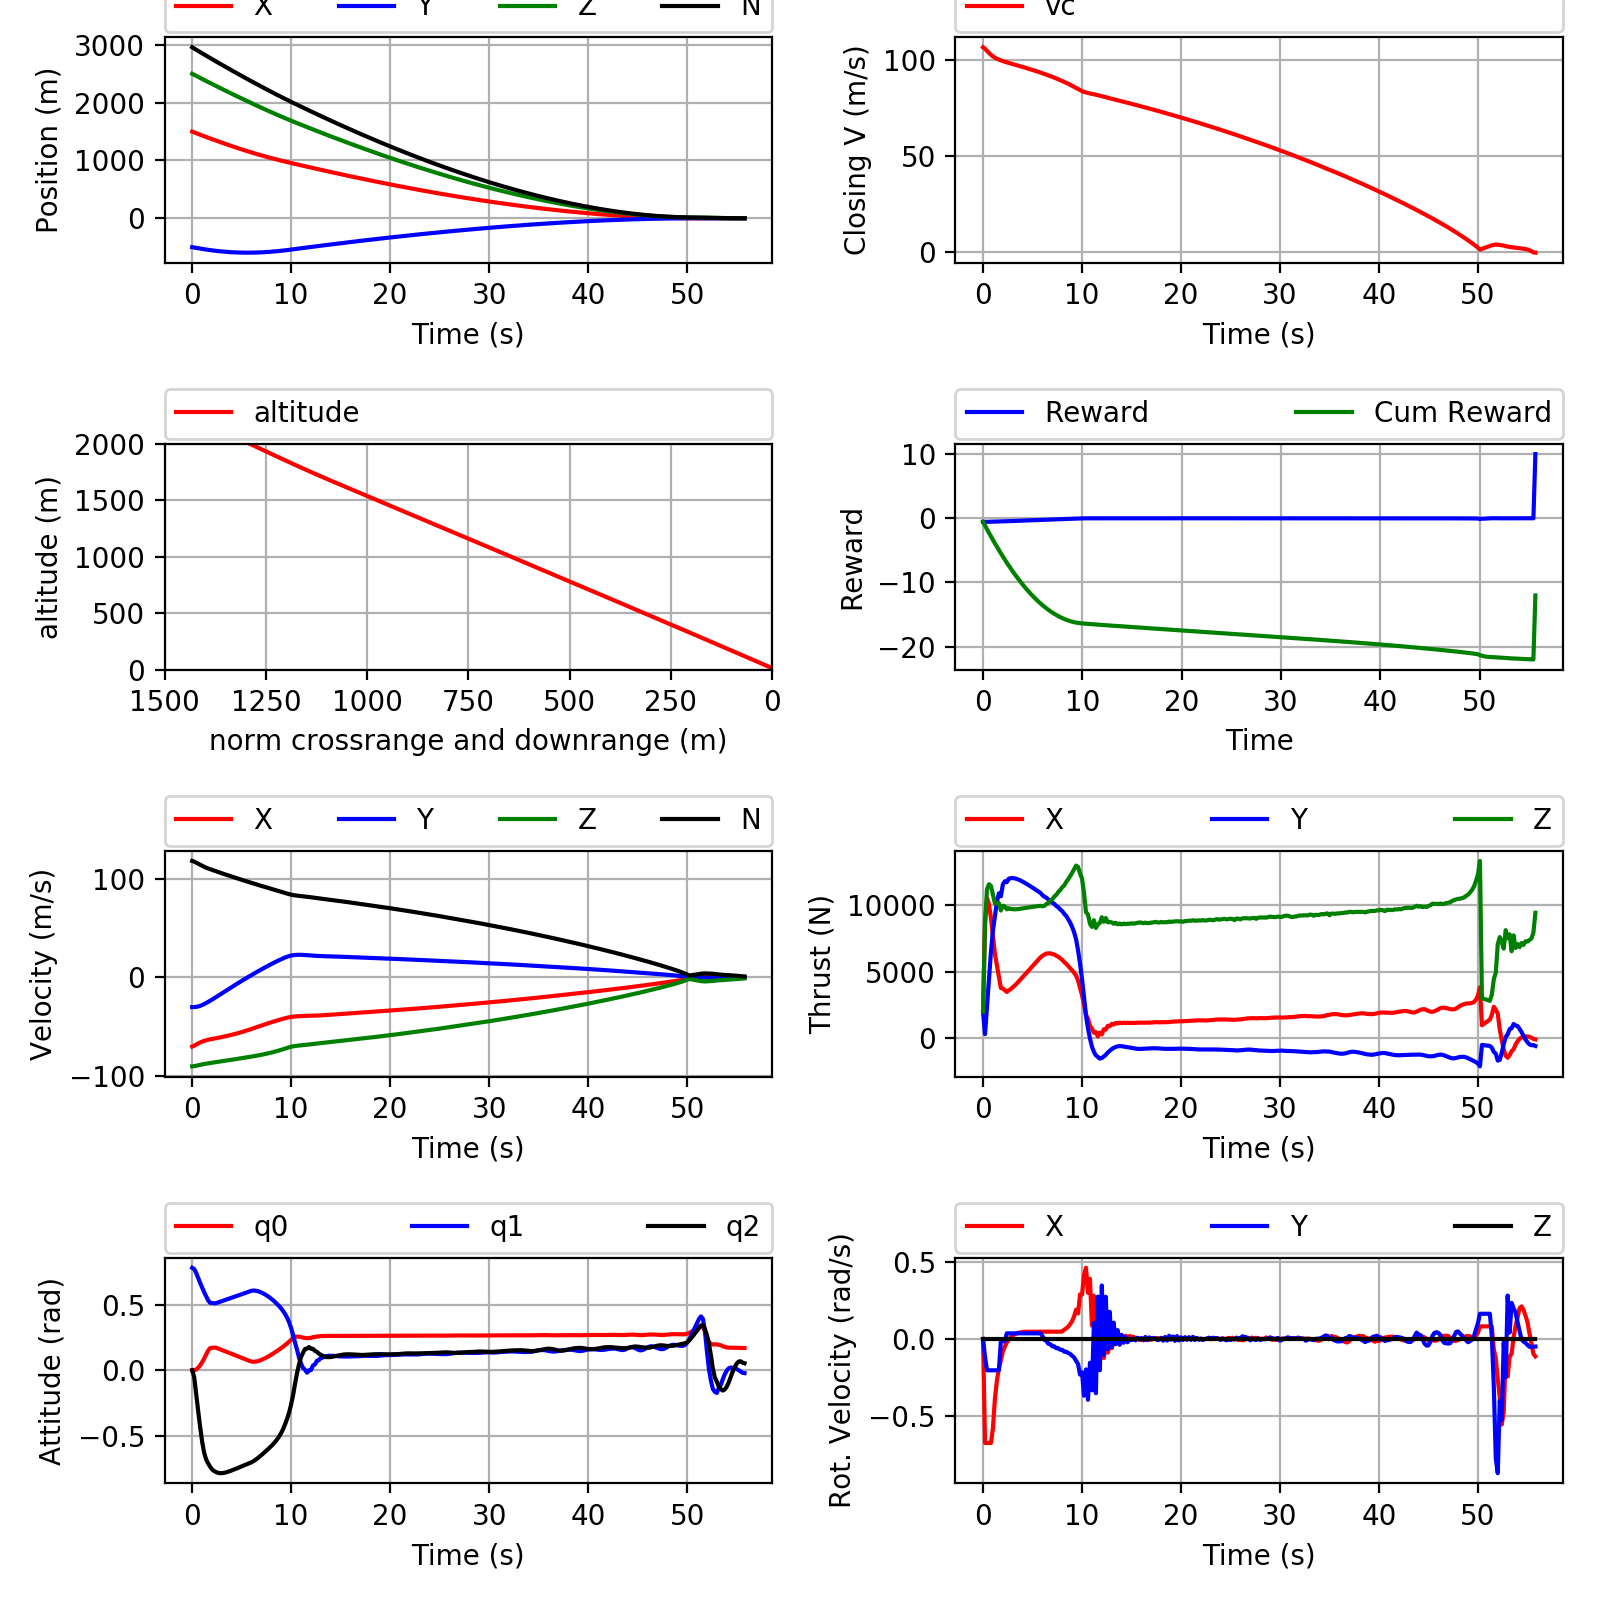

In [11]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (1500,1500 , -70, -70), 
                           crossrange = (-500,-500 , -30,-30),  
                           altitude = (2500,2500,-90,-90),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1,print_every=1)
envu.render_traj(env.lander.trajectory_list[0])

In [83]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10.)
lander_model.get_state_agent = lander_model.get_state_agent9
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           downrange = (500,2500 , -70, -10), 
                           crossrange = (-500,500 , -0,0),  
                           altitude = (1900,2100,-90,-70),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)
#envu.render_traj(lander_model.trajectory_list[0])

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model fixed:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9619.11 |2674.05 |3200.00 |16000.00 |    95
glideslope | 2.271 | 6.434 | 0.626 |843.702 |    21
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.2     0.0 |    -1.8    -0.7    -0.0 |     1.1     0.5    -0.0
velocity |  -0.071  -0.105  -0.815 |   0.015   0.024   0.079 |  -0.118  -0.169  -1.090 |  -0.034  -0.024  -0.639
fuel     |284.16 | 22.49 |247.03 |347.56
attitude |  -0.008   0.004  -0.007 |   0.073   0.007   0.011 |  -0.145  -0.009  -0.036 |   0.230   0.022   0.018
w        |  -0.010   0.003   0.000 |   0.021   0.013   0.000 |  -0.057  -0.030  -0.000 |   0.060   0.039   0.000
gli

position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.0    -0.0 |     1.3     1.0    -0.0
velocity |  -0.072  -0.106  -0.823 |   0.015   0.024   0.074 |  -0.119  -0.177  -1.090 |   0.009   0.009  -0.473
fuel     |282.46 | 22.50 |241.33 |365.23
attitude |  -0.010   0.004  -0.006 |   0.079   0.006   0.011 |  -0.283  -0.016  -0.036 |   0.324   0.025   0.033
w        |  -0.012   0.004   0.000 |   0.020   0.014   0.000 |  -0.066  -0.110  -0.000 |   0.093   0.080   0.000
glideslope |   9.348 |   1.453 |   6.460 |  18.491
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9755.91 |2718.25 |3200.00 |16000.00 |    95
glideslope | 2.360 | 5.372 | 0.455 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.0    -0.0 |     1.6     1.0    -0.0
velocity |  -0.072  -0.106  -0.823 |   0.015   0.024   0.074 |  -0.119  -0.177  -1.090 |   0.009   0.0

i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.28 |2705.73 |3200.00 |16000.00 |    95
glideslope | 2.375 | 5.138 | 0.407 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.025   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.473
fuel     |281.67 | 22.07 |241.33 |365.23
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.324   0.025   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.080   0.000
glideslope |   9.388 |   1.405 |   6.460 |  18.491
i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9761.05 |2705.93 |3200.00 |16000.00 |    95
glideslope | 2.373 | 5.134 | 0.407 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  3300
Cumulative Stats (mean,std,max,argmax)
thrust   |9763.51 |2697.45 |3200.00 |16000.00 |    95
glideslope | 2.388 | 5.249 | 0.397 |1179.051 |  2724
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.025   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.473
fuel     |281.48 | 21.83 |240.07 |365.23
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.026   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.080   0.000
glideslope |   9.384 |   1.442 |   6.324 |  24.694
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9765.20 |2699.25 |3200.00 |16000.00 |    95
glideslope | 2.382 | 5.221 | 0.397 |1179.051 |  2724
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  4400
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.05 |2700.20 |3200.00 |16000.00 |    95
glideslope | 2.372 | 5.364 | 0.397 |1638.535 |  3753
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.408
fuel     |281.62 | 21.89 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.029   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.385 |   1.422 |   6.321 |  24.694
i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9758.91 |2700.48 |3200.00 |16000.00 |    95
glideslope | 2.371 | 5.353 | 0.397 |1638.535 |  3753
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  5500
Cumulative Stats (mean,std,max,argmax)
thrust   |9758.51 |2703.28 |3200.00 |16000.00 |    95
glideslope | 2.370 | 6.017 | 0.383 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.1    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.123  -0.178  -1.162 |   0.026   0.011  -0.377
fuel     |281.88 | 21.98 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.029   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.380 |   1.430 |   5.996 |  24.694
i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.37 |2704.12 |3200.00 |16000.00 |    95
glideslope | 2.368 | 5.992 | 0.383 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.99 |2703.07 |3200.00 |16000.00 |    95
glideslope | 2.356 | 5.956 | 0.373 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.024   0.076 |  -0.123  -0.178  -1.169 |   0.026   0.011  -0.377
fuel     |282.13 | 22.03 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.380 |   1.430 |   5.256 |  24.694
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9755.14 |2702.32 |3200.00 |16000.00 |    95
glideslope | 2.357 | 5.940 | 0.373 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  7700
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.26 |2702.99 |3200.00 |16000.00 |    95
glideslope | 2.350 | 6.182 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.134  -0.178  -1.169 |   0.033   0.040  -0.377
fuel     |282.09 | 22.08 |239.08 |372.86
attitude |  -0.012   0.004  -0.006 |   0.078   0.006   0.011 |  -0.324  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.373 |   1.429 |   5.256 |  24.694
i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.47 |2703.10 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.162 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  8800
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.76 |2701.10 |3200.00 |16000.00 |    95
glideslope | 2.353 | 5.991 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.024   0.076 |  -0.134  -0.178  -1.169 |   0.033   0.040  -0.377
fuel     |281.98 | 22.12 |239.08 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.324  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.381 |   1.438 |   5.256 |  24.694
i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.46 |2701.26 |3200.00 |16000.00 |    95
glideslope | 2.351 | 5.976 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  9900
Cumulative Stats (mean,std,max,argmax)
thrust   |9753.88 |2703.68 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.050 | 0.298 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.8    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.134  -0.186  -1.169 |   0.033   0.045  -0.377
fuel     |282.09 | 22.19 |239.08 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.347  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.384 |   1.437 |   5.256 |  24.694

Cumulative Stats (mean,std,max,argmax)
thrust   |9753.14 |2703.21 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.038 | 0.298 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (m

In [68]:
I = lander_model.nominal_inertia_tensor.copy()
print(I)
rot = np.random.uniform(low=np.pi/16,high=np.pi/16,size=3)
#rot=np.zeros(3)
C = attu.Euler3212DCM(rot)
I_new = C.dot(I).dot(C.T)
print(I_new)

[[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
[[2045.67228049  -44.79470043 -225.19816651]
 [ -44.79470043 2043.93398282  220.87104689]
 [-225.19816651  220.87104689 3110.39373668]]


In [26]:
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Euler_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)
lander_model.apf_pot = lander_model.apf_pot2
reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, landing_rlimit=100, landing_vlimit=10,fuel_coeff=-0.05)

glideslope_constraint = Glideslope_constraint(gs_limit=0.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10)
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9657.62 |2840.75 |3200.00 |16000.00 |    76
glideslope | 2.020 | 1.236 | 0.950 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.9     0.1    -0.0 |     0.2     0.4     0.0 |     0.3    -0.7    -0.0 |     1.3     1.0    -0.0
velocity |   0.063   0.038  -0.758 |   0.063   0.097   0.151 |  -0.037  -0.159  -1.068 |   0.272   0.315  -0.272
fuel     |284.95 | 12.66 |254.18 |318.12
attitude |  -0.081  -0.038  -0.003 |   0.131   0.037   0.033 |  -0.477  -0.121  -0.075 |   0.208   0.053   0.076
w        |  -0.011   0.145  -0.001 |   0.030   0.028   0.006 |  -0.074   0.037  -0.012 |   0.053   0.195   0.015
glideslope |   2.796 |   0.515 |   1.712 |   4.612
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9660.51 |2835.66 |3200.00 |16000.00 |    76
glideslope | 2.077 | 1.335 | 0.844 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats

KeyboardInterrupt: 

In [71]:
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen3_old import Landing_icgen
from thruster_model import Thruster_model

dynamics_model = Dynamics_model()
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)

env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=0.0, debug=False,
                           yaw   = (-np.pi/32, np.pi/32, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/32, np.pi/4, -0.01, 0.01),
                           inertia_uncertainty_diag=0.0, 
                           inertia_uncertainty_offdiag=0.0,
                           roll  = (-np.pi/32, np.pi/32, -0.01, 0.01))


policy.test_mode=True
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

6dof dynamics model
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander max thrust:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  5.0
 - apf_tau1:  20
 - apf_tau2:  250
lander env att 2 fixed
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9681.35 |2813.38 |3200.00 |16000.00 |    12
glideslope | 2.072 | 1.289 | 0.652 |62.772 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |     0.4    -1.7    -0.1 |     2.1     0.9    -0.0
velocity |   0.185  -0.018  -0.887 |   0.209   0.260   0.227 |  -0.000  -0.522  -1.464 |   1.062   0.927  -0.324
fuel     |283.46 | 10.52 |255.06 |312.35
attitude |  -0.019  -0.053  -0.018 |   0.336   0.040   0.042 |  -0.755  -0.152  -0.116 |   0.693   0.036   0.139
w        |  -0.013   0.141   0.001 |   0.051   0.046   0.006 |  -0.100  -0.1

position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.8    -0.1 |     2.5     1.3    -0.0
velocity |   0.170   0.022  -0.856 |   0.179   0.245   0.207 |  -0.019  -0.639  -1.604 |   1.062   0.987  -0.287
fuel     |283.84 | 11.41 |255.06 |325.78
attitude |  -0.067  -0.049  -0.011 |   0.323   0.038   0.042 |  -0.760  -0.175  -0.116 |   0.693   0.083   0.139
w        |  -0.007   0.140  -0.000 |   0.045   0.037   0.006 |  -0.153  -0.108  -0.010 |   0.232   0.241   0.010
glideslope |   2.416 |   0.506 |   1.182 |   3.838
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9676.37 |2815.65 |3200.00 |16000.00 |    12
glideslope | 2.126 | 1.988 | 0.553 |472.776 |   524
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.168   0.016  -0.857 |   0.178   0.244   0.206 |  -0.026  -0.639  -1.612 |   1.062   0.98

i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.48 |2812.60 |3200.00 |16000.00 |    12
glideslope | 2.149 | 2.260 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.016  -0.850 |   0.173   0.238   0.206 |  -0.026  -0.639  -1.700 |   1.151   1.078  -0.251
fuel     |283.75 | 11.16 |254.72 |325.78
attitude |  -0.061  -0.048  -0.011 |   0.318   0.038   0.042 |  -0.760  -0.178  -0.139 |   0.693   0.119   0.139
w        |  -0.008   0.140  -0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.232   0.241   0.010
glideslope |   2.428 |   0.510 |   1.149 |   4.232
i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9674.03 |2811.60 |3200.00 |16000.00 |    12
glideslope | 2.147 | 2.256 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  3300
Cumulative Stats (mean,std,max,argmax)
thrust   |9675.36 |2814.85 |3200.00 |16000.00 |    12
glideslope | 2.137 | 2.053 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.017  -0.850 |   0.173   0.240   0.203 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.89 | 11.28 |252.79 |325.78
attitude |  -0.061  -0.048  -0.010 |   0.319   0.038   0.042 |  -0.771  -0.178  -0.145 |   0.719   0.119   0.139
w        |  -0.008   0.141  -0.000 |   0.044   0.038   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.428 |   0.512 |   1.149 |   4.291
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.41 |2813.99 |3200.00 |16000.00 |    12
glideslope | 2.135 | 2.032 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  4400
Cumulative Stats (mean,std,max,argmax)
thrust   |9679.16 |2816.71 |3200.00 |16000.00 |  3879
glideslope | 2.130 | 1.960 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.171   0.239   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.98 | 11.21 |252.18 |325.78
attitude |  -0.058  -0.048  -0.010 |   0.317   0.038   0.042 |  -0.771  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.435 |   0.511 |   1.119 |   4.291
i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9678.46 |2816.81 |3200.00 |16000.00 |  3879
glideslope | 2.128 | 1.987 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  5500
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.67 |2815.65 |3200.00 |16000.00 |  3879
glideslope | 2.127 | 1.964 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.170   0.240   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.97 | 11.19 |252.18 |325.78
attitude |  -0.057  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.439 |   0.517 |   1.119 |   6.114
i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.39 |2815.07 |3200.00 |16000.00 |  3879
glideslope | 2.129 | 1.954 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.99 |2815.72 |3200.00 |16000.00 |  3879
glideslope | 2.126 | 2.376 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -2.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.163   0.017  -0.849 |   0.170   0.242   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.95 | 11.27 |251.67 |325.78
attitude |  -0.059  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.210  -0.155 |   0.719   0.119   0.151
w        |  -0.009   0.142   0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.433 |   0.516 |   1.119 |   6.114
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.55 |2815.81 |3200.00 |16000.00 |  3879
glideslope | 2.124 | 2.364 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

KeyboardInterrupt: 